<a href="https://colab.research.google.com/github/sgr1118/NLP_basic/blob/main/_11_%ED%86%A0%ED%94%BD_%EB%AA%A8%EB%8D%B8%EB%A7%81(Topic_Modeling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 토픽 모델링(Topic Modeling)

* 토픽 모델링은 문서 집합에서 주제를 찾아내기 위한 기술
* 토픽 모델링은 '특정 주제에 관한 문서에서는 특정 단어가 자주 등장할 것이다'라는 직관을 기반
* 예를 들어, 주제가 '개'인 문서에서는 개의 품종, 개의 특성을 나타내는 단어가 다른 문서에 비해 많이 등장
* 텍스트 마이닝 기법 중에서 가장 많이 활용되는 기법 중 하나
* 대표 토픽 모델링 방법으로 잠재 의미 분석(Latent Semantic Analysis)과 잠재 디리클레 할당(Latent Dirichlet Allocation) 기법이 있음

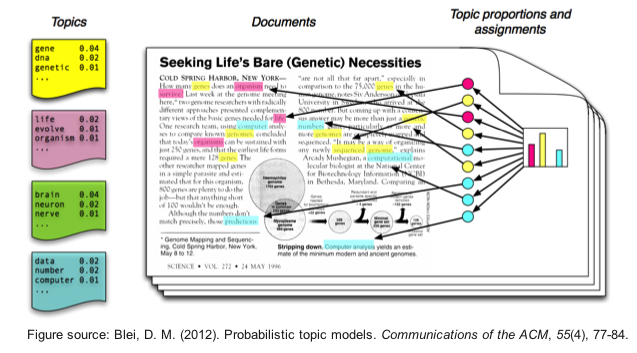

* Gensim: 벡터 변환, 토픽 모델링, 텍스트 요약 등 자연어와 텍스트마이닝 관련 여러 기능을 제공하고 있는 라이브러리

In [ ]:
#!pip install --upgrade gensim

## 뉴스그룹 데이터 준비

In [1]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle = True, random_state = 123,
                             remove = ('headers', 'footers', 'quotes'))

print(len(dataset.data))
print(dataset.target_names)

dataset.data[1]

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


11314
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


'From article <1993Apr18.000152.2339@gnv.ifas.ufl.edu>, by jrm@gnv.ifas.ufl.edu:\n\nOnly irrational fools such as yourself are set against RKBA.  There are\n*plenty* of people who support it.\n\n\nThe government will be overthrown *long* before that happens.  A *huge* \nmillitia composed of all available men and women who care about their\ncountry will defeat the forces of the evil Klintonistas.  The people\n*will* prevail!\n\nOh, so you think armed citizens alone can\'t overthrow the government?\nConsider this:  do you think *all* law enforcement officials and members\nof the Armed Forces will turn against the people that they are entrusted\nto serve?  Not hardly.  You can count on a lot of people in the Army,\nMarines, Air Force, Navy, National Guard, police officers, and so on\njoining in the cause to defend the liberties and freedoms of American\ncitizens.  COUNT ON IT!  THE GOVERNMENT WILL NOT BE ABLE TO DISARM\nEVERYONE WITHOUT STARTING A CIVIL WAR!\n\n\nWrong again.  People will

In [2]:
import pandas as pd

news_df = pd.DataFrame({'article':dataset.data})
print(len(news_df))
news_df.replace('', float('NaN'), inplace = True)
news_df.dropna(inplace=True)
print(len(news_df))

11314
11096


In [5]:
import re
import nltk
import string
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import preprocess_string

nltk.download('stopwords')

def clean_text(d):
    d = str(d).lower() # 소문자화
    d = re.sub('\[.*?\]', '', d) # 불필요한 특수 기호 제거
    d = re.sub('<.*?>+', '', d) # 태그 제거
    d = re.sub('[%s]' % re.escape(string.punctuation), '', d) # 구두점 제거
    d = re.sub('\n', '', d) # 줄바꿈 기호 제거
    d = re.sub('\w*\d\w*', '', d) #
    return d

def clean_stopwords(d):
    stop_words = stopwords.words('english') + ['u', 'im', 'c'] # 불용어 제거
    return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])
    # 불용어에 포함되지 않고 단어 길이가 3이상이 문자를 추출하고 소문자로 바꾼다.

def preprocessing(d):
    return preprocess_string(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 데이터 확인

news_df['article']

0        A quick query for Powerbook gurus:\nTom Spearm...
1        From article <1993Apr18.000152.2339@gnv.ifas.u...
2        \nSteve, take a look at what you are saying.  ...
3        I have a routine that changes the color (RGB) ...
4        \nI sometimes wonder if Kekule's dream wasn't ...
                               ...                        
11309    \n\ni would like to remind my jewish colleague...
11310    \nProbably because everyone (that is, everyone...
11311    THere is a defect in the 13" hi-res monitors, ...
11312    \na lot of batters lean in when pitches come. ...
11313    Howdy,\n\nI'm a little new to this newsgroup, ...
Name: article, Length: 11096, dtype: object

In [5]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        a quick query for powerbook gurustom spearman ...
1        from article  by jrmgnvifasufleduonly irration...
2        steve take a look at what you are saying  i do...
3        i have a routine that changes the color rgb at...
4        i sometimes wonder if kekules dream wasnt just...
                               ...                        
11309    i would like to remind my jewish colleague mzm...
11310    probably because everyone that is everyone who...
11311    there is a defect in the  hires monitors bring...
11312    a lot of batters lean in when pitches come  ri...
11313    howdyim a little new to this newsgroup but i w...
Name: article, Length: 11096, dtype: object

In [6]:
news_df['article'] = news_df['article'].apply(clean_stopwords)
news_df['article']

0        quick query powerbook gurustom spearman post a...
1        article jrmgnvifasufleduonly irrational fools ...
2        steve take look saying dont construvtiveword d...
3        routine changes color attributes myvga adapter...
4        sometimes wonder kekules dream wasnt influence...
                               ...                        
11309    would like remind jewish colleague much thesto...
11310    probably everyone everyone cable watchevery br...
11311    defect hires monitors bring dealer replace fly...
11312    batters lean pitches come rickeys crouch tends...
11313    howdyim little newsgroup would like theknowled...
Name: article, Length: 11096, dtype: object

In [7]:
tokenized_news = news_df['article'].apply(preprocessing)
tokenized_news = tokenized_news.to_list()
tokenized_news[1]

['articl',
 'jrmgnvifasufleduonli',
 'irrat',
 'fool',
 'rkba',
 'areplenti',
 'peopl',
 'support',
 'itth',
 'govern',
 'overthrown',
 'long',
 'happen',
 'huge',
 'millitia',
 'compos',
 'avail',
 'women',
 'care',
 'theircountri',
 'defeat',
 'forc',
 'evil',
 'klintonista',
 'peoplewil',
 'prevailoh',
 'think',
 'arm',
 'citizen',
 'overthrow',
 'governmentconsid',
 'think',
 'enforc',
 'offici',
 'membersof',
 'arm',
 'forc',
 'turn',
 'peopl',
 'entrustedto',
 'serv',
 'hardli',
 'count',
 'peopl',
 'armymarin',
 'forc',
 'navi',
 'nation',
 'guard',
 'polic',
 'offic',
 'onjoin',
 'caus',
 'defend',
 'liberti',
 'freedom',
 'americancitizen',
 'count',
 'govern',
 'abl',
 'disarmeveryon',
 'start',
 'civil',
 'warwrong',
 'peopl',
 'hide',
 'gun',
 'officersmor',
 'like',
 'jackboot',
 'stormtroop',
 'abl',
 'themthei',
 'idiot',
 'realiz',
 'dontthen',
 'includ',
 'believ',
 'describehappen',
 'come',
 'gun',
 'disarm',
 'citizenswould',
 'requir',
 'everyon',
 'cherish',
 'fre

### gensim Error

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

- gensim 4.2와 numpy가 호환성에서 오류가 난 것으로 추측된다.

해결방법
- pip install --upgrade numpy

In [14]:
#pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [8]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(tokenized_news)
print(len(dictionary))

dictionary.filter_extremes(keep_n = 2000, no_below = 5, no_above = 0.5)
# no_below, no_above : 단어의 빈도 필터링
# keep_n : 단어 개수 제한

print(len(dictionary))

corpus = [dictionary.doc2bow(text) for text in tokenized_news]
print(len(corpus))

121898
2000
11096


## 잠재 의미 분석(Latent Semantic Analysis)

* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)로도 알려져 있음
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정
* LSA는 문서 모음에서 생성한 문서-단어 행렬(Document Term Matrix)에서 단어-토픽 행렬(Term-Topic Matrix)과 토픽-중요도 행렬(Topic-Importance Matrix), 그리고 토픽-문서 행렬(Topic-Document Matrix)로 분해

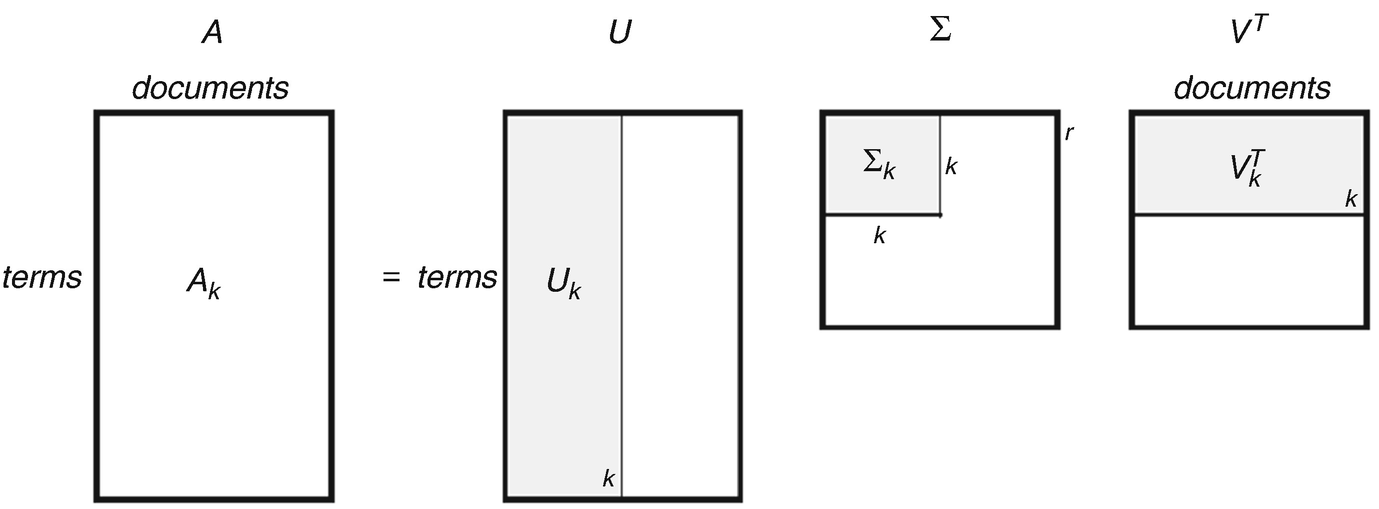

<small>Anandarajan, M., Hill, C., Nolan, T. (2019). Semantic Space Representation and Latent Semantic Analysis. In: Practical Text Analytics. Advances in Analytics and Data Science, vol 2. Springer, Cham. https://doi.org/10.1007/978-3-319-95663-3_6</small>

## 잠재 의미 분석을 위한 `LsiModel`

In [9]:
from gensim.models import LsiModel

lsi_model = LsiModel(corpus, num_topics = 10, id2word=dictionary)
topics = lsi_model.print_topics(num_topics = 10)
topics

[(0,
  '0.245*"file" + 0.191*"program" + 0.153*"imag" + 0.151*"peopl" + 0.134*"avail" + 0.133*"dont" + 0.130*"work" + 0.129*"anonym" + 0.129*"know" + 0.127*"like"'),
 (1,
  '0.280*"file" + -0.230*"know" + -0.228*"peopl" + -0.221*"said" + 0.206*"imag" + -0.188*"dont" + -0.172*"think" + 0.151*"program" + -0.142*"go" + -0.141*"didnt"'),
 (2,
  '-0.700*"wire" + -0.272*"ground" + -0.215*"circuit" + -0.173*"connect" + -0.158*"neutral" + -0.131*"cabl" + -0.123*"electr" + -0.117*"instal" + -0.100*"requir" + -0.098*"usual"'),
 (3,
  '0.435*"anonym" + -0.310*"entri" + 0.236*"post" + -0.236*"file" + 0.221*"internet" + -0.198*"program" + 0.189*"privaci" + 0.153*"servic" + 0.147*"mail" + 0.140*"user"'),
 (4,
  '-0.433*"entri" + 0.307*"drive" + 0.260*"imag" + -0.250*"file" + 0.194*"disk" + 0.175*"support" + -0.157*"anonym" + 0.146*"data" + 0.128*"avail" + 0.126*"control"'),
 (5,
  '0.475*"drive" + -0.335*"imag" + 0.272*"disk" + 0.238*"entri" + 0.221*"control" + 0.192*"hard" + 0.171*"bio" + 0.135*"ca

* 응집도(Coherence)
  * 토픽이 얼마나 의미론적으로 일관성이 있는지 판단
  * 값이 높을수록 의미론적 일관성이 높음
  * 해당 모델이 얼마나 실제로 의미있는 결과를 내는지 확인
  * 다른 외부 데이터(Corpus, Thesaurus)를 이용해 평가 진행

In [11]:
from gensim.models.coherencemodel import CoherenceModel

min_topics, max_topics = 5, 15
coherence_scores = []

for num_topics in range(min_topics, max_topics):
    model = LsiModel(corpus, num_topics = num_topics, id2word=dictionary)
    coherence = CoherenceModel(model = model,
                               texts = tokenized_news,
                               dictionary = dictionary,
                               coherence='u_mass')
    coherence_scores.append(coherence.get_coherence())

print(coherence_scores)

[-2.157324146695513, -2.3446055111767117, -2.1804847327922166, -2.1954428193769098, -2.421784939495617, -2.5786503137192094, -2.6279955233670123, -2.5582749624027623, -2.7252742787802506, -2.7829833515078346]


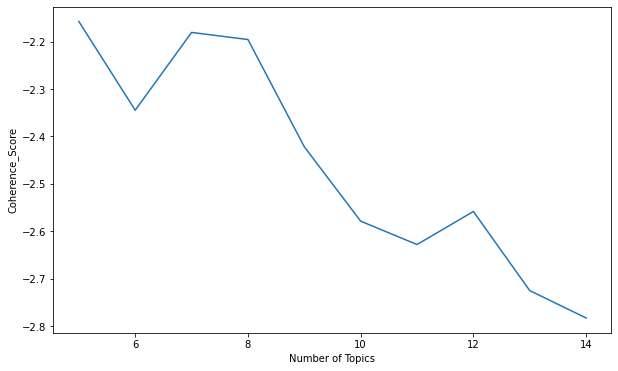

In [13]:
import matplotlib.pyplot as plt

x = [int(i) for i in range(min_topics, max_topics)]

plt.figure(figsize = (10,6))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence_Score')

plt.show()

# 현재 상태에서는 topics = 6이 가장 높다.

In [14]:
lsi_model = LsiModel(corpus, num_topics = 6, id2word = dictionary)
lsi_model.print_topics(num_topics = 6)

[(0,
  '0.245*"file" + 0.191*"program" + 0.153*"imag" + 0.151*"peopl" + 0.134*"avail" + 0.133*"dont" + 0.130*"work" + 0.129*"anonym" + 0.129*"know" + 0.127*"like"'),
 (1,
  '-0.280*"file" + 0.230*"know" + 0.228*"peopl" + 0.221*"said" + -0.206*"imag" + 0.188*"dont" + 0.172*"think" + -0.151*"program" + 0.142*"go" + 0.141*"didnt"'),
 (2,
  '-0.700*"wire" + -0.272*"ground" + -0.215*"circuit" + -0.173*"connect" + -0.158*"neutral" + -0.131*"cabl" + -0.123*"electr" + -0.117*"instal" + -0.100*"requir" + -0.098*"usual"'),
 (3,
  '0.435*"anonym" + -0.310*"entri" + 0.236*"post" + -0.236*"file" + 0.221*"internet" + -0.198*"program" + 0.189*"privaci" + 0.153*"servic" + 0.147*"mail" + 0.140*"user"'),
 (4,
  '-0.433*"entri" + 0.307*"drive" + 0.260*"imag" + -0.250*"file" + 0.194*"disk" + 0.175*"support" + -0.157*"anonym" + 0.146*"data" + 0.128*"avail" + 0.126*"control"'),
 (5,
  '-0.475*"drive" + 0.335*"imag" + -0.272*"disk" + -0.238*"entri" + -0.221*"control" + -0.192*"hard" + -0.171*"bio" + -0.135*"

## 잠재 디리클레 할당(Latent Dirichlet Allocation)

* 잠재 디레클레 할당(LDA)은 대표적인 토픽 모델링  알고리즘 중 하나

* 잠재 디레클레 할당 방법
  1. 사용자가 토픽 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 $w$가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

* $p(t|d)$: 문서 $d$의 단어들 중 토픽 $t$에 해당하는 비율, 해당 문서의 자주 등장하는 다른 단어의 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미    
* $p(w|t)$: 단어 w를 가지고 있는 모든 문서들 중  토픽 $t$가 할당된 비율, 다른 문서에서 단어 $w$에 많이 할당된 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미

* 즉, LDA는 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽 추출

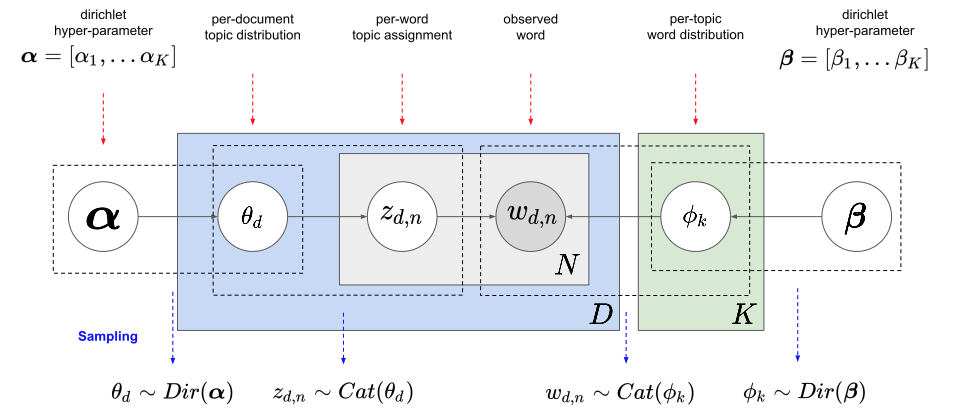

<small>그림 출처: https://donghwa-kim.github.io/lda.html</small>

* $K$: 토픽 수
* $D$: 문서 수
* $N$: 특정 문서의 단어 수
* $w_{d,n}$: 특정 문서 $d$에서 $n$번째 단어로 관측된 값
* $z_{d,n}$ topic: 특정 문서 $d$에서 $n$번째 단어에 대한 topic assignment
  * $z_{d,n}$는 Multinomial($\theta_d$)에서 샘플링 된 것($\theta_d$: Multinomial 분포의 모수)
  * Multinomial($\theta_d$)는 한번만 시행(샘플)된 것으로 Categorical($\theta_d$)와 동일
  * $\theta_d=[\theta_{d,1}, \theta_{d,2},..., \theta_{d,K}]∈\mathbb{R}^K$
  * $\sum_{k}\theta_{d, k}=1,\theta_{d, k} \geq 0$, ($k$: topic index)는 $d$번째 문서의 $Dirichlet_d$($\alpha$)에서 샘플링
  * $\alpha=[\alpha_1, \alpha_2, ..., \alpha_K]$, symmetry할 경우 $\alpha_1 = \alpha_2 =  ... = \alpha_K$
* $w_{d,n}$ word: 특정 문서 $d$에서 $n$번째 단어
  * $w_{d,n}$는 Multinomial($\beta_k$)에서 샘플링 된 것($\beta_k$: Multinomial 분포의 모수)
  * Multinomial($\phi_k$)는 한번만 시행(샘플)된 것으로 Categorical($\phi_k$)와 동일
  * $\phi_k=[\phi_{k,1},\phi_{k,2},..., \phi_{k,V}]∈\mathbb{R}^V$
  * $\sum_{i}\phi_{k, v}=1,\phi_{v, i} \geq 0$, ($v$: vocabulary index)는 $k$번째 문서의 $Dirichlet_k$($\beta$)에서 샘플링
  * $\beta=[\beta_1, \beta_2, ..., \beta_V]$, symmetry할 경우 $\beta_1 = \beta_2 =  ... = \beta_V$

## 잠재 디리클레 할당을 위한 `LdaModel`

In [15]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus, num_topics = 10, id2word = dictionary)
lda_model.print_topics(num_topics = 10)

[(0,
  '0.021*"peopl" + 0.010*"think" + 0.010*"armenian" + 0.010*"dont" + 0.009*"believ" + 0.007*"know" + 0.007*"like" + 0.007*"said" + 0.006*"right" + 0.005*"want"'),
 (1,
  '0.008*"state" + 0.006*"question" + 0.006*"govern" + 0.006*"israel" + 0.005*"jesu" + 0.005*"secur" + 0.005*"mean" + 0.005*"peopl" + 0.005*"time" + 0.005*"fact"'),
 (2,
  '0.024*"game" + 0.022*"team" + 0.014*"plai" + 0.013*"year" + 0.013*"hockei" + 0.013*"player" + 0.011*"leagu" + 0.010*"season" + 0.009*"chip" + 0.007*"number"'),
 (3,
  '0.017*"space" + 0.013*"orbit" + 0.011*"time" + 0.010*"mission" + 0.009*"nasa" + 0.009*"rate" + 0.008*"program" + 0.007*"satellit" + 0.007*"year" + 0.007*"data"'),
 (4,
  '0.011*"year" + 0.010*"said" + 0.010*"time" + 0.010*"start" + 0.009*"didnt" + 0.009*"know" + 0.008*"good" + 0.006*"like" + 0.006*"dont" + 0.006*"go"'),
 (5,
  '0.016*"know" + 0.013*"like" + 0.013*"think" + 0.013*"dont" + 0.009*"work" + 0.009*"thing" + 0.008*"time" + 0.008*"presid" + 0.008*"go" + 0.008*"want"'),
 (6

* 혼란도(Perplexity)
  * 의미 확률 모델이 결과를 얼마나 정확하게 예측하는지 판단하는 기준
  * 토픽 모델링 기법이 얼마나 빠르게 수렴하는지 확인 가능
  * 선정된 토픽 갯수마다 학습시켜 가장 낮은 값을 보이는 구간을 찾아 최적화된 토픽 개수 선정 가능
  * 동일 모델 내에서 파라미터에 따라 성능 평가를 할 때 주로 사용
  * Perplexity가 낮다고 해서 결과 해석이 용이하다는 의미는 아님


In [16]:
from gensim.models.coherencemodel import CoherenceModel

min_topics, max_topics = 5, 15
perplexity_values = []
coherence_scores = []

for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics = num_topics, id2word=dictionary)
    perplexity_values.append(model.log_perplexity(corpus))
    coherence = CoherenceModel(model = model,
                               texts = tokenized_news,
                               dictionary = dictionary,
                               coherence='u_mass')
    coherence_scores.append(coherence.get_coherence())

print(perplexity_values)
print(coherence_scores)

[-7.027093691759895, -7.000481045038848, -7.010898882518033, -6.9716911860970665, -6.971004085264724, -6.998742000004191, -7.003334140729138, -7.010362067670193, -7.004971841314372, -7.00534413766934]
[-1.847913037842894, -1.8520433974536923, -2.035765248975078, -1.8657318467562973, -1.959234282017184, -2.1158428276019263, -2.063062084431546, -2.356870963055468, -2.2035878816715306, -2.0591775907564136]


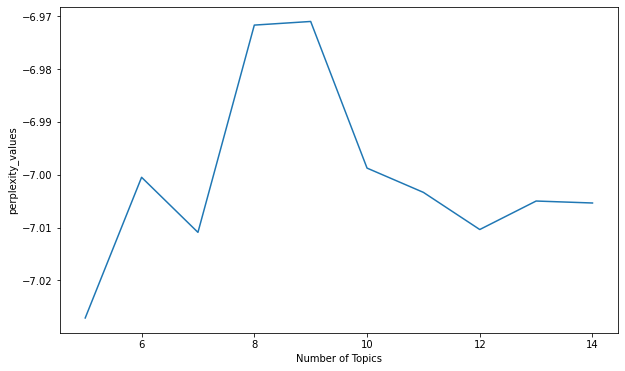

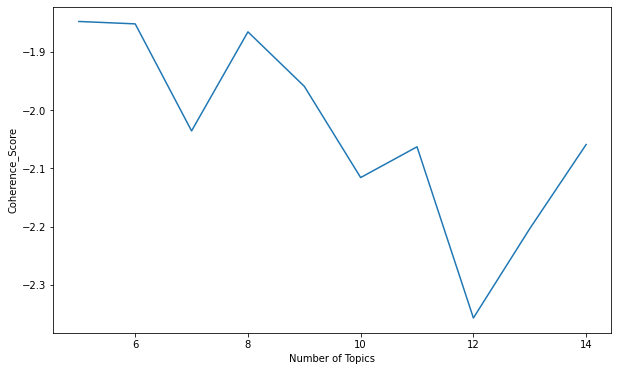

In [19]:
import matplotlib.pyplot as plt

x = [int(i) for i in range(min_topics, max_topics)]

plt.figure(figsize = (10,6))
plt.plot(x, perplexity_values)
plt.xlabel('Number of Topics')
plt.ylabel('perplexity_values')
plt.show()

plt.figure(figsize = (10,6))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence_Score')
plt.show()
# 현재 상태에서는 topics = 8이 가장 높다.
# perplexity_values의 값이 낮고 Coherence_Score가 높은 topics를 사용한다.

In [21]:
lda_model = LdaModel(corpus, num_topics = 8 , id2word = dictionary)
topics = lda_model.print_topics(num_topics = 8)
print(topics)

cm = CoherenceModel(model = lda_model, corpus = corpus, coherence='u_mass')
coherence = cm.get_coherence()
print('coherence: ', coherence)
print('perplexity: ', lda_model.log_perplexity(corpus))

[(0, '0.013*"file" + 0.011*"window" + 0.011*"imag" + 0.010*"program" + 0.009*"avail" + 0.008*"like" + 0.007*"softwar" + 0.007*"data" + 0.007*"anonym" + 0.007*"version"'), (1, '0.010*"state" + 0.009*"govern" + 0.007*"encrypt" + 0.007*"right" + 0.007*"chip" + 0.007*"secur" + 0.006*"nation" + 0.005*"year" + 0.005*"inform" + 0.005*"administr"'), (2, '0.009*"like" + 0.008*"engin" + 0.008*"bike" + 0.008*"time" + 0.008*"line" + 0.007*"water" + 0.007*"tire" + 0.006*"need" + 0.006*"simm" + 0.006*"ride"'), (3, '0.016*"peopl" + 0.013*"know" + 0.013*"armenian" + 0.011*"dont" + 0.010*"time" + 0.010*"said" + 0.009*"think" + 0.008*"presid" + 0.007*"want" + 0.006*"work"'), (4, '0.012*"think" + 0.012*"peopl" + 0.011*"dont" + 0.010*"like" + 0.010*"know" + 0.008*"believ" + 0.007*"game" + 0.007*"good" + 0.006*"thing" + 0.006*"time"'), (5, '0.009*"window" + 0.008*"moral" + 0.007*"valu" + 0.007*"differ" + 0.007*"mean" + 0.006*"dont" + 0.006*"peopl" + 0.006*"applic" + 0.006*"thing" + 0.006*"think"'), (6, '0.

## LDA 시각화를 위한 `pyLDAvis`

In [23]:
!pip install -Uqq pyLDAvis==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 43.2 MB/s eta 0:00:00


In [24]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model,corpous, dictionary) 
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary) # colab 모듈이 변경 이슈로 인하여 코드 수정
pyLDAvis.display(vis)

# 겹치지 않는 토픽 모음은 주제가 겹치지 않는다는 것을 뜻한다.

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


# 토픽 트렌드(Topic Trends)

* 시간에 따라 토픽의 변화 살펴보기
* 사이킷런(Scikit-learn)의 LDA를 이용한 토픽 모델링

## 뉴스 헤드라인 데이터 준비

* ABC 뉴스 헤드라인 (18년, 2003-02-19 ~ 2020-12-31)
* 뉴스 헤드라인 데이터: http://suanlab.com/datasets/abcnews-date-text.csv
* 출처: https://www.kaggle.com/therohk/million-headlines

In [1]:
!wget http://suanlab.com/datasets/abcnews-date-text.csv

--2023-02-05 07:55:16--  http://suanlab.com/datasets/abcnews-date-text.csv
Resolving suanlab.com (suanlab.com)... 52.219.144.88
Connecting to suanlab.com (suanlab.com)|52.219.144.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62726972 (60M) [text/csv]
Saving to: ‘abcnews-date-text.csv.1’

abcnews-date-text.c 100%[===================>]  59.82M  11.3MB/s    in 6.9s    

2023-02-05 07:55:23 (8.71 MB/s) - ‘abcnews-date-text.csv.1’ saved [62726972/62726972]



In [2]:
import pandas as pd

df = pd.read_csv('abcnews-date-text.csv')
df

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1226253,20201231,what abc readers learned from 2020 looking bac...
1226254,20201231,what are the south african and uk variants of ...
1226255,20201231,what victorias coronavirus restrictions mean f...
1226256,20201231,whats life like as an american doctor during c...


In [3]:
df_2020 = df[df.publish_date >= 20100101] # 20100101 이후 데이터만 추출
df_2020 = df_2020.reset_index(drop = True) # 인덱스 제거
df_2020

,publish_date,headline_text
0,20100101,12m degas stolen from museum
1,20100101,17 die in bangladesh bus crash
2,20100101,2010 to be drier after very wet 2009
3,20100101,37 catholic workers killed worldwide
4,20100101,600 hurt in philippine new year revelry
...,...,...
715948,20201231,what abc readers learned from 2020 looking bac...
715949,20201231,what are the south african and uk variants of ...
715950,20201231,what victorias coronavirus restrictions mean f...
715951,20201231,whats life like as an american doctor during c...


In [6]:
df_2020['headline_text'] = df_2020['headline_text'].apply(clean_stopwords)
df_2020['headline_text'] = df_2020['headline_text'].apply(preprocessing)
tokenized_doc = df_2020['headline_text'].apply(lambda x: [word for word in x if len(word) > 3])
tokenized_doc[1]

['bangladesh', 'crash']

In [7]:
detokeniezd_headline = []
for i in range(len(df_2020)):
    t = ' '.join(tokenized_doc[i])
    detokeniezd_headline.append(t)

df_2020['headline_text'] = detokeniezd_headline
df_2020['headline_text']

0                                 dega stolen museum
1                                   bangladesh crash
2                                              drier
3                        cathol worker kill worldwid
4                        hurt philippin year revelri
                             ...                    
715948                        reader learn look year
715949                   south african variant covid
715950        victoria coronaviru restrict mean year
715951          what life like american doctor covid
715952    women shed canberra reskil unemploi pandem
Name: headline_text, Length: 715953, dtype: object

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english', max_features = 1000)
headline_cv = cv.fit_transform(df_2020['headline_text'])
print(headline_cv.shape)

f_names = cv.get_feature_names_out()
print(f_names)

(715953, 1000)
['abbott' 'aborigin' 'abus' 'access' 'accid' 'accus' 'action' 'activist'
 'adam' 'address' 'adelaid' 'admit' 'affect' 'afghan' 'afghanistan'
 'africa' 'agreement' 'agricultur' 'ahead' 'airport' 'alan' 'alcohol'
 'alert' 'alic' 'alleg' 'allegedli' 'allow' 'america' 'amid' 'analysi'
 'andrew' 'anger' 'anim' 'anniversari' 'announc' 'answer' 'anti' 'anzac'
 'apologis' 'appeal' 'appear' 'appl' 'appoint' 'approv' 'april' 'area'
 'armi' 'arrest' 'arriv' 'artist' 'asbesto' 'asia' 'asian' 'assault'
 'assist' 'asylum' 'attack' 'attempt' 'august' 'aussi' 'australia'
 'australian' 'author' 'avoid' 'awai' 'award' 'babi' 'bail' 'bali' 'bank'
 'barrier' 'base' 'bash' 'basin' 'battl' 'beach' 'beat' 'beef' 'begin'
 'bendigo' 'benefit' 'best' 'better' 'bike' 'biki' 'billion' 'bird'
 'bishop' 'black' 'blame' 'blast' 'blaze' 'block' 'blog' 'blow' 'blue'
 'board' 'boat' 'bodi' 'bomb' 'bomber' 'book' 'boom' 'boost' 'border'
 'boss' 'brawl' 'breach' 'break' 'breakfast' 'bridg' 'brief' 'bring'


### BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable. Error

- 직렬화 해제하지못하는 오류

해결방법
- pip install --upgrade pandas==1.2.0

In [36]:
#!pip install --upgrade pandas==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires pandas>=1.3, but you have pandas 1.2.0 which is incompatible.


In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=7, n_jobs = -1, random_state = 123)
headline_topics = lda_model.fit_transform(headline_cv)

n_top_words = 20
for idx, topic in enumerate(lda_model.components_):
    print('topic: ', idx)
    print([(f_names[i], topic[i].round(3)) for i in topic.argsort()[:-n_top_words:-1]])

topic:  0
[('sydnei', 7726.129), ('warn', 7139.392), ('coast', 6182.313), ('claim', 4964.716), ('trial', 4843.022), ('flood', 4842.715), ('protest', 4778.926), ('gold', 4282.142), ('polic', 3360.527), ('dead', 3259.01), ('forc', 3234.899), ('island', 3111.436), ('storm', 2997.142), ('research', 2834.486), ('bodi', 2724.108), ('break', 2655.142), ('asylum', 2466.142), ('emerg', 2409.92), ('chief', 2313.504)]
topic:  1
[('plan', 10050.428), ('china', 6027.046), ('hous', 5723.445), ('worker', 4633.142), ('kill', 4610.703), ('power', 4395.732), ('continu', 3802.103), ('lead', 3683.536), ('tasmania', 3215.742), ('leav', 3198.141), ('lose', 3102.008), ('road', 3080.96), ('deal', 3040.208), ('final', 2993.943), ('reveal', 2849.521), ('cost', 2808.236), ('million', 2728.075), ('aussi', 2693.142), ('public', 2676.458)]
topic:  2
[('australian', 12296.324), ('open', 7018.633), ('farmer', 5890.142), ('rise', 5200.777), ('market', 5006.639), ('price', 4974.934), ('water', 4752.541), ('farm', 4377.

In [10]:
trend_data = pd.DataFrame(headline_topics, columns = ['Topic' + str(i) for i in range(1,8)])
trend_data = pd.concat([trend_data, pd.to_datetime(df.publish_date, format= '%Y%m%d')], axis = 1)
trend_data.set_index('publish_date')

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
publish_date,,,,,,,
2003-02-19,0.071429,0.071522,0.071429,0.071429,0.071432,0.571308,0.071453
2003-02-19,0.071429,0.071429,0.071429,0.071578,0.071429,0.571279,0.071429
2003-02-19,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2003-02-19,0.047619,0.714182,0.047619,0.047719,0.047619,0.047621,0.047620
2003-02-19,0.287186,0.035743,0.534034,0.035765,0.035754,0.035786,0.035732
...,...,...,...,...,...,...,...
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
trend = trend_data.groupby(['publish_date']).mean()
trend

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
publish_date,,,,,,,
2003-02-19,0.190598,0.126805,0.120040,0.122397,0.118830,0.208502,0.112829
2003-02-20,0.165189,0.157244,0.124349,0.148613,0.126344,0.173726,0.104535
2003-02-21,0.146029,0.152416,0.157680,0.130782,0.112260,0.192277,0.108556
2003-02-22,0.111996,0.143433,0.137897,0.120781,0.140852,0.220393,0.124648
2003-02-23,0.125081,0.158764,0.152159,0.173166,0.149945,0.108561,0.132324
...,...,...,...,...,...,...,...
2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


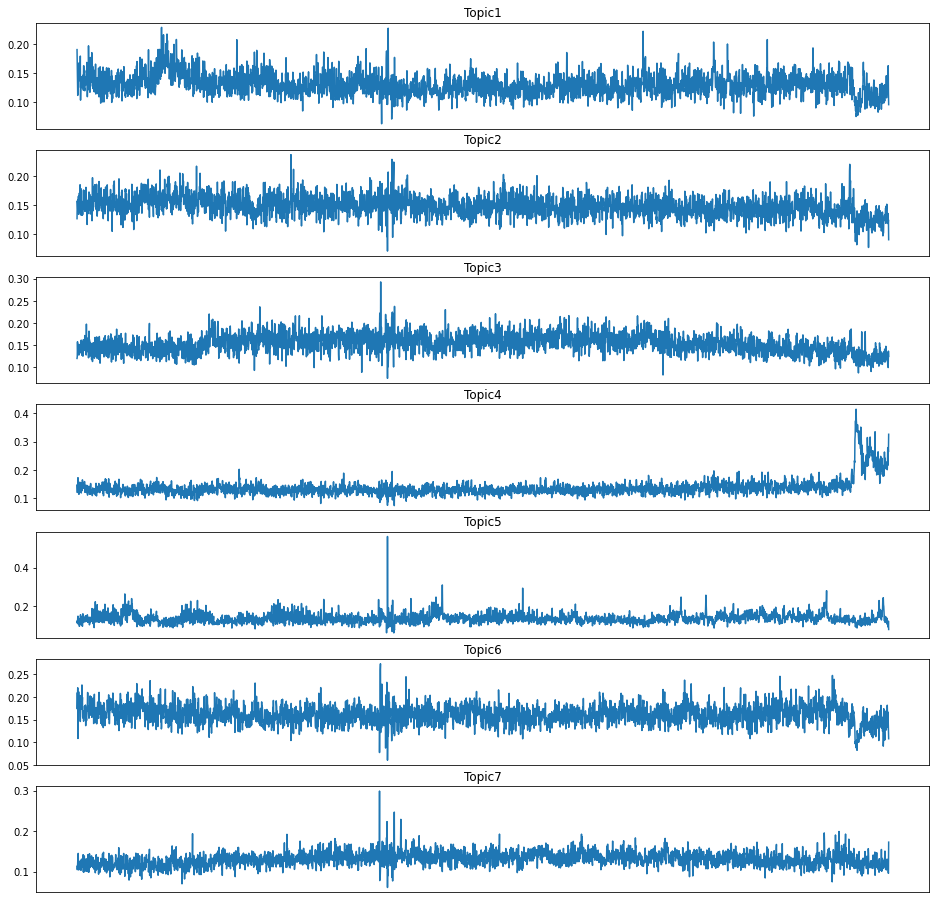

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(7, 1, sharex = 'col', figsize = (16, 16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

## 청원 데이터 준비

* 청원 데이터: https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv
* 출처: https://github.com/akngs/petitions

* 한국어 자연어 처리 konlpy 라이브러리와 형태소 분석기 MeCab 설치
* 설치 명령어: 
`!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash`

* 혼란도(Perplexity) 계산

# BERTopic

* 신경망 토픽 모델링(Neural topic modeling)
* https://arxiv.org/pdf/2203.05794.pdf